# Exponential data 02

_Adapted from Josep Fortiana (2023-03-13) by Jordi Abante (2024-03-25)_

## Modelling Earthquake Waiting Times

#### Data and explanations, from [Tutorial on Bayesian Data Analysis by Ankit Tewari](https://rstudio-pubs-static.s3.amazonaws.com/370794_abaf71444ad04cd0b05c0a8d41b4de98.html).

We're going to practise how to model the waiting times between serious earthquakes using a bayesian approach.   
The United States Geological Survey maintains a list of significant earthquakes worldwide.   
We will model the rate of earthquakes of magnitude 4.0+ in the state of California during 2015.   
An iid exponential model on the waiting time between significant earthquakes is appropriate if we assume:

1. Earthquake events are independent,
2. The rate at which earthquakes occur does not change during the year, and 
3. The earthquake hazard rate does not change (i.e., the probability of an earthquake happening tomorrow is constant regardless of whether the previous earthquake was yesterday or 100 days ago).

### Earthquake data:

The significant earthquakes of magnitude 4.0+ in the state of California during 2015 occurred on the following dates :

January 4, January 20, January 28, May 22, July 21, July 25, August 17, September 16, December 30. 

Let $ Y_{i}$ denote the waiting time in days between the $i$-th earthquake and the following earthquake. Our model is 

$$
    Y_{i}\mskip8mu\text{i.i.d.}\sim\mskip8mu\operatorname{Exponential}(\lambda),
$$

where the expected waiting time between earthquakes is $\operatorname{E}(Y)=1/\lambda$ days.

Assume the conjugate prior $ \lambda\sim\operatorname{Gamma}(\alpha,\beta)$. Suppose our prior expectation for $\lambda$ is $1/30$, and we wish to use a prior effective sample size of one interval between earthquakes.

A good question then is that what is the value of $\alpha$ and $\beta$ so that we can use them in our prior distribution? Well, as you might have guessed, we can use $\alpha=1$ and $\beta=30$. It is so because in the exponential-gamma model, $\alpha$ is the prior effective sample size and the prior mean is $\alpha/\beta=1/30$, and since we know the effective sample size $\alpha=1$, we have $\beta=30$.

The reason why $ \alpha$ is called _prior effective sample size_ is the updating formula. If  the prior pdf for $\lambda$ is a $\operatorname{Gamma}$ with parameters $\alpha$ and $\beta$, and an experiment is performed, taking $n$ independent exponential observations $y=(y_{1},\dots,y_{n})$ with average $\overline{y}$, the posterior pdf for $\lambda$ is a $\operatorname{Gamma}$ with parameters $\alpha'$ and $\beta'$:

$$
    \left\{
    \begin{array}{lcl}
    \alpha'&=&\alpha+n,\\
    \beta'&=&\beta+n\,\overline{y}.
    \end{array}\right.
$$

thus we might think of the prior pdf as information from $n_{0}=\alpha$ virtual observations with average $\beta$.

Which of the following is our data vector? The first of the following:

$$
    \begin{array}{lcl}
    y &= &(16, 8, 114, 60, 4, 23, 30, 105),\\
    y &= &(3, 16, 8, 114, 60, 4, 23, 30, 105, 1),\\
    y &= &(3, 16, 8, 114, 60, 4, 23, 30, 105).
    \end{array}
$$

Recall that we are modeling the waiting times between earthquakes in days. There are eight intervals between the first and last event. We are excluding four days of the year in which no events were observed. A more comprehensive model (e.g., censoring methods) would account for the fact that there were no major earthquakes Jan. 1 to Jan. 4 and Dec. 30 to Dec. 31. This is beyond the scope of this tutorial.

In [1]:
prior.a<-1
prior.b<-30

# A.1. Simulate from the prior pdf

In [2]:
N<-10000
Sim.lambda.prior<-rgamma(N,prior.a,prior.b)

In [3]:
Theor.lambda.mean<-prior.a/prior.b
# Theor.lambda.mode<-(prior.a-1)/prior.b  # For alpha>1, 0 for alpha=1.
Theor.lambda.var<-prior.a/prior.b^2
Theor.lambda.sd<-sqrt(Theor.lambda.var)
round(Theor.lambda.mean,4)
round(Theor.lambda.var,4)
round(Theor.lambda.sd,4)

[1] 0.0333

[1] 0.0011

[1] 0.0333

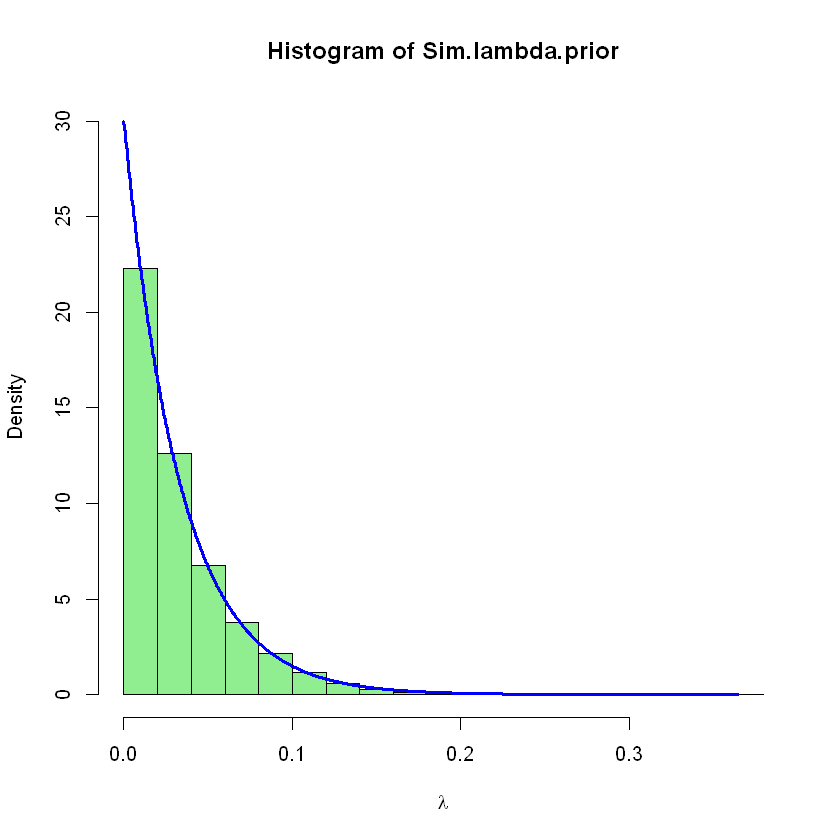

In [4]:
# Plot histogram, compare with the theoretical Gamma pdf 
options(repr.plot.width=7,repr.plot.height=7)
hist(Sim.lambda.prior,freq=FALSE,col="LightGreen",xlab=expression(lambda),ylim=c(0,30),breaks=25)
v<-seq(0,max(Sim.lambda.prior),length=1000)
lines(v,dgamma(v,shape=prior.a,rate=prior.b),lwd=2.5,col="blue")

# A.2. Simulate from the prior predictive pdf

The prior predictive joint pdf, for an $ n$-sample, is:

$$
f(y_{1},\dots,y_{n})=\dfrac{\Gamma(\alpha+n)}{\Gamma(\alpha)}
    \cdot\dfrac{\beta^{\alpha}}{(n\,\overline{y}+\beta)^{\alpha+n}},\mskip20mu
        y_{1}>0,\dots,y_{n}>0.
$$

We can use it for $ n=1$, to check a single observation from this distribution,

$$
f(y)=\dfrac{\Gamma(\alpha+1)}{\Gamma(\alpha)}
    \cdot\dfrac{\beta^{\alpha}}{(y+\beta)^{\alpha+1}}
    =\alpha\cdot\dfrac{\beta^{\alpha}}{(y+\beta)^{\alpha+1}},\mskip20mu y>0.
$$

In this case the predictive distribution is a [Pareto II (Lomax)](https://en.wikipedia.org/wiki/Lomax_distribution). The expectation is:

$$
    \operatorname{E}(Y)=\dfrac{\beta}{\alpha-1},\mskip20mu\alpha>1,\mskip30mu
    \operatorname{var}(Y)=\dfrac{\beta^{2}\,\alpha}{(\alpha-1)^{2}\,(\alpha-2)},\mskip20mu \alpha>2,
$$

The Lomax distribution is a special case of the [generalized Pareto distribution](https://en.wikipedia.org/wiki/Generalized_Pareto_distribution). 

$$
    f_{(\mu,\sigma,\xi)}(y)=\dfrac{1}{\sigma}
    \left(1+\dfrac{\xi\,(y-\mu)}{\sigma }\right)^{\left(-{\frac {1}{\xi}}-1\right)},
$$

where the support is  $ y\geq\mu$ when $\xi\geq0$, and $\mu\leq y\leq\mu-\sigma/\xi$ when  $\xi<0$. Specifically:

$$
    \mu =0,\mskip20mu \xi =\dfrac{1}{\alpha},\mskip20mu \sigma=\dfrac{\beta}{\alpha}.
$$

In [5]:
Theor.pred.pdf<-function(y,a,b){return(ifelse(y>0,a*b^{a}/(y+b)^(a+1),0))}

In [6]:
# Simulate from the prior predictive. Likelihood is exponential with parameter lambda
Sim.y<-rexp(N,rate=Sim.lambda.prior)

In [7]:
str(Sim.y)
summary(Sim.y)
q.Sim.y<-quantile(Sim.y,c(0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9))
round(q.Sim.y,2)
ymax<-max(q.Sim.y)
round(ymax,2)
Sim.y.trunc<-Sim.y[Sim.y<ymax]  # truncate in order to be able to plot the histogram
str(Sim.y.trunc)

 num [1:10000] 93.97 161.81 494.68 5.22 1.97 ...


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
     0.0     10.3     29.8    319.7     90.3 581275.5 

5%    10%    20%    30%    40%    50%    60%    70%    80%    90% 
  1.66   3.40   7.81  13.20  20.22  29.84  44.91  70.98 123.92 276.45

[1] 276.45

 num [1:9000] 93.97 161.81 5.22 1.97 30.84 ...


#### There is no theoretical expectation nor variance, as `prior.a=1`

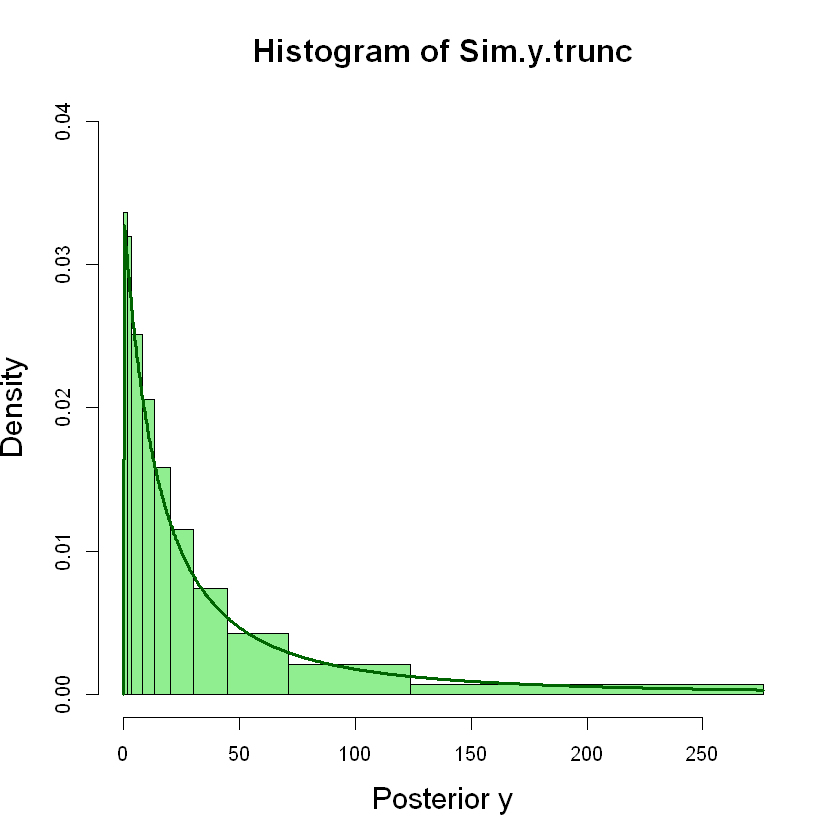

In [8]:
# Plot histogram, 
options(repr.plot.width=7,repr.plot.height=7)
ymax<-max(q.Sim.y)
u<-seq(0,ymax,length=1000)
yu<-Theor.pred.pdf(u,a=prior.a,b=prior.b)
hist(Sim.y.trunc,freq=FALSE,col="LightGreen",breaks=c(min(Sim.y.trunc),q.Sim.y,max(Sim.y.trunc)),
     ylim=c(0,0.040),xlab="Posterior y",cex.lab=1.5,cex.main=1.6)
lines(u,yu,lwd=2.5,col="DarkGreen")

# A.3. Simulate from the posterior pdf

In [9]:
y<-c(16, 8, 114, 60, 4, 23, 30, 105)
n<-length(y)
ybar<-mean(y)
round(ybar,2)
nybar<-sum(y)

[1] 45

Posterior pdf is $ \lambda\sim\operatorname{Gamma}(\alpha',\beta')$,

$$
    \left\{
    \begin{array}{lcl}
    \alpha'&=&\alpha+n,\\[0.2cm]
    \beta'&=&\beta+n\,\overline{y}.
    \end{array}\right.
$$

In [10]:
post.a<-prior.a+n
post.b<-prior.b+nybar
post.a
post.b

[1] 9

[1] 390

In [11]:
Theor.lambda.post.mean<-post.a/post.b
Theor.lambda.post.mode<-(post.a-1)/post.b  # For alpha>1, 0 for alpha=1.
Theor.lambda.post.var<-post.a/post.b^2
Theor.lambda.post.sd<-sqrt(Theor.lambda.post.var)
round(Theor.lambda.post.mean,4)
round(Theor.lambda.post.mode,4)
round(Theor.lambda.post.var,6)
round(Theor.lambda.post.sd,4)

[1] 0.0231

[1] 0.0205

[1] 5.9e-05

[1] 0.0077

In [12]:
N1<-10000 
Sim.lambda.post<-rgamma(N1,post.a,post.b)

Well understood, this is _not_ an actual posterior sample, it is a sample from the distribution we _know_ will be the posterior, from the theory of conjugate pairs.

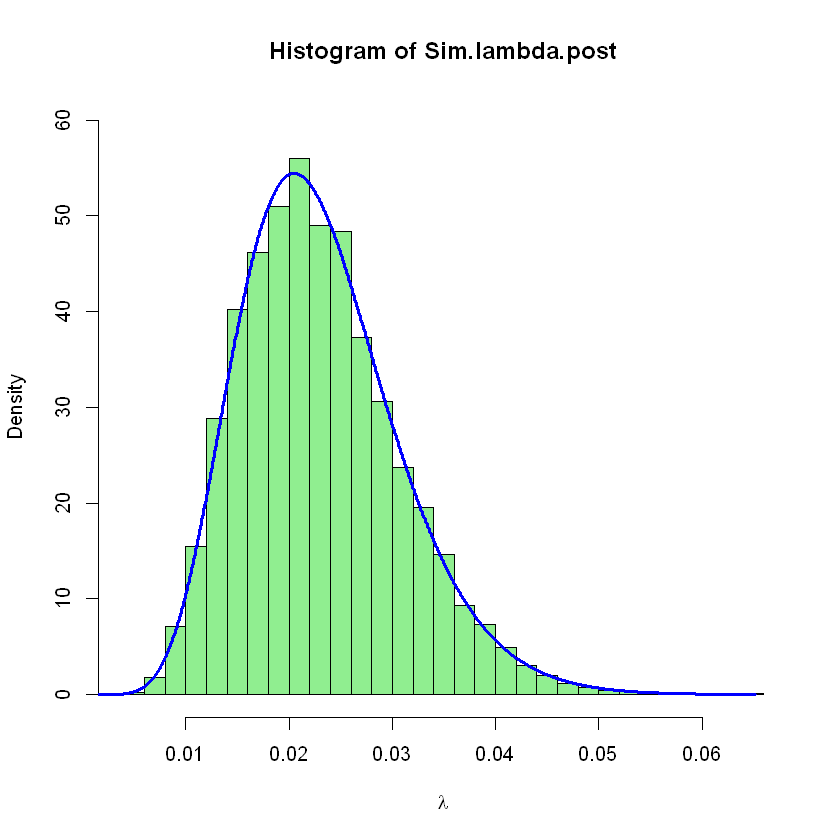

In [13]:
# Plot histogram, superimpose the Gamma pdf 
options(repr.plot.width=7,repr.plot.height=7)
v<-seq(0,max(Sim.lambda.post),length=1000)
yv<-dgamma(v,shape=post.a,rate=post.b)
max.yv<-max(yv)
hist(Sim.lambda.post,freq=FALSE,col="LightGreen",xlab=expression(lambda),ylim=c(0,max.yv*1.1),breaks=25)
lines(v,yv,lwd=2.5,col="blue")

# A.4. Simulate from the posterior predictive pdf

In [15]:
# Simulate from the prior predictive. Likelihood is exponential with parameter lambda
N2<-N1
Sim.y.pred<-rexp(N2,rate=Sim.lambda.post)

In [16]:
str(Sim.y)
summary(Sim.y.pred)
q.Sim.y.pred<-quantile(Sim.y.pred,c(0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9))
round(q.Sim.y.pred,2)
ymax<-max(q.Sim.y.pred)
round(ymax,2)
Sim.y.pred.trunc<-Sim.y.pred[Sim.y.pred<ymax]  # truncate in order to be able to plot the histogram
str(Sim.y.pred.trunc)

 num [1:10000] 93.97 161.81 494.68 5.22 1.97 ...


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   12.92   31.82   48.74   64.58  810.84 

5%    10%    20%    30%    40%    50%    60%    70%    80%    90% 
  2.08   4.49   9.96  16.04  23.04  31.82  42.55  55.96  76.66 112.45

[1] 112.45

 num [1:9000] 22.6 20 36.9 19.5 11.6 ...


In [17]:
Theor.post.E.y<-post.b/(post.a-1)
Theor.post.var.y<-post.b^2*post.a/((post.a-1)^2*(post.a-2))
Theor.post.sd.y<-sqrt(Theor.post.var.y)
round(Theor.post.E.y,3)
round(Theor.post.var.y,3)
round(Theor.post.sd.y,3)

[1] 48.75

[1] 3055.58

[1] 55.277

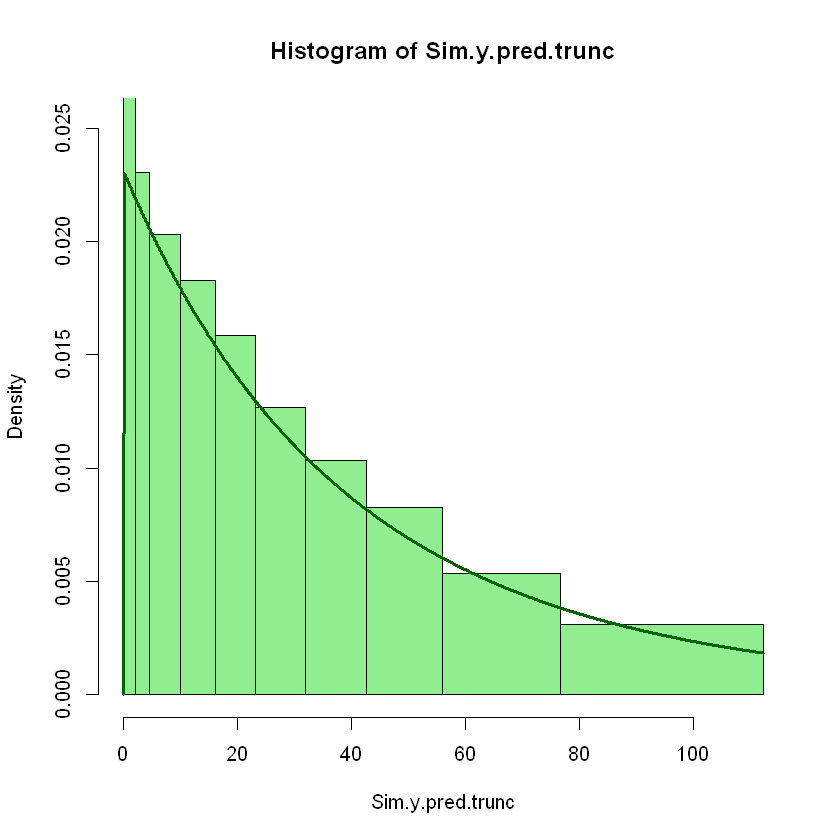

In [18]:
# Plot histogram, 
options(repr.plot.width=7,repr.plot.height=7)
u<-seq(0,ymax,length=1000)
yu<-Theor.pred.pdf(u,a=post.a,b=post.b)
ymax<-max(yu)
hist(Sim.y.pred.trunc,freq=FALSE,col="LightGreen",
     breaks=c(min(Sim.y.pred.trunc),q.Sim.y.pred,max(Sim.y.pred.trunc)),ylim=c(0,ymax*1.1))
lines(u,yu,lwd=2.5,col="DarkGreen")